<a href="https://colab.research.google.com/github/FloraBBN2/dotfiles/blob/master/classify_electrocardiograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify Electrocardiograms (ECG)

<img src='https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg' width=400>

🧑🏻‍🏫 We saw in the first challenge that **Recurrent Neural Networks are well designed to work with sequence prediction problems**: based on an observed sequence of data, RNN are used to predict what will happen next (predicting the next value(s) of a temperature, a stock price, ... $ \rightarrow $ ***regression task***).

👉 Let's see here a different way to use RNNs. Instead of predicting a value that occurs after the observed sequence, we will here ***classify the entire sequence*** itself, as if the whole sequence would correspond to a given category. 

🎯 Exercise objectives:
- Discover a new type of application with temporal data: classification
- Try different RNN architectures.

## (1) The ECG dataset

* The data corresponds to electrocardiograms (ECG), which are basically heartbeats.
    - Each sequence is therefore a sequence of amplitudes. 
    - These ECGs are often used to observe heart malfunctions! 
* In this dataset, there are 87554 heartbeats and each of them corresponds to a heartbeat type, ranging from 0 to 4:
    - 0 : Normal beat
    - 1 : Supraventricular
    - 2 : Ventricular
    - 3 : Fusion
    - 4 : Beats that cannot be classified

### (1.1) Loading the dataset

<u><b>Instructions:</b></u>
* Run the following command to download the data from [here](https://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip)
* Unzip them
* Read it as python object

In [1]:
! wget "http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip"
! unzip ECG_data.zip
! rm ECG_data.zip

--2022-05-19 13:13:34--  http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.250.188.208, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30932601 (29M) [application/zip]
Saving to: ‘ECG_data.zip’

ECG_data.zip        100%[===================>]  29.50M  84.3MB/s    in 0.4s    

2022-05-19 13:13:34 (84.3 MB/s) - ‘ECG_data.zip’ saved [30932601/30932601]

Archive:  ECG_data.zip
replace ECG_data/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import numpy as np

X = np.load('ECG_data/X.npy', allow_pickle=True).tolist()
y = np.load('ECG_data/y.npy', allow_pickle=True).tolist()

print(len(X), "time series") 

87554 time series


### (1.2) Visualizing some ECGs

🎁 We gave you a piece of Python code to plot one ECG for each category in the dataset 

👩🏻‍⚕️ *Run the following cell* to see what an ECG looks like for each category.

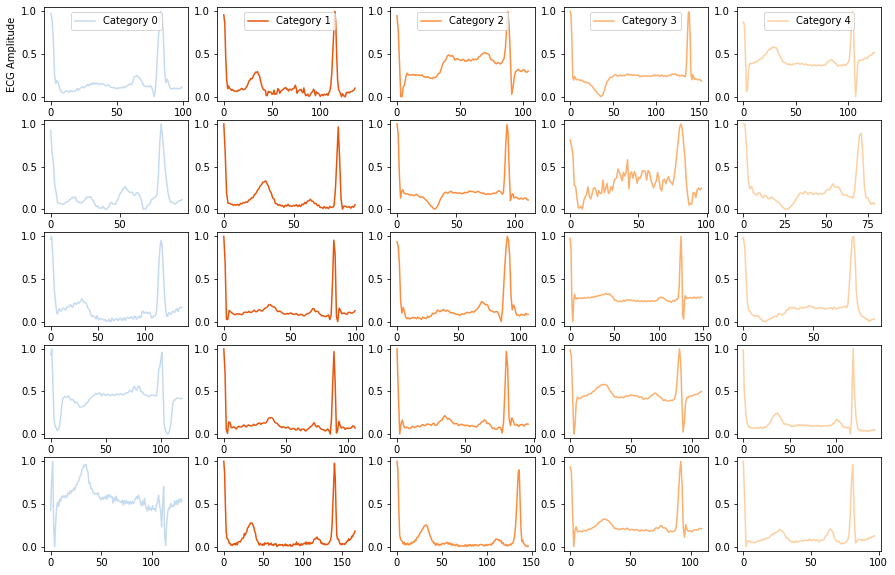

In [3]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ------------------------- #
#      Some colormaps       #
# ------------------------- #

name = "tab20c"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_list = cmap.colors


# ------------------------- #
#      Some ECG             #
# ------------------------- #

fix, axs = plt.subplots(5,5, figsize=(15,10))

for i in range(5): # Five examples per category
    for j in range(5): # Iterating over the 5 categories
        idx_C = np.argwhere(np.array(y) == j)  # Collecting the indexes of all the heartbeats of category j
        axs[i,j].plot(X[idx_C[i][0]], label=f'Category {j}', c=colors_list[j+3]) # Plotting the ECG
        # Some cosmetic tricks down below
        if i == 0:
            axs[i,j].legend(loc='upper center')
            if j ==0:
                axs[i,j].set_xlabel('Time')
                axs[i,j].set_ylabel('ECG Amplitude')

### (1.3) Padding the sequences

🕵🏻‍♂️ You have (probably ?) notice that each sequence, i.e. each ECG, has a different length.

❓ **Question** ❓ Plot the distribution of the sequences' lengths in the dataset to confirm this observation.

In [4]:
len(X[1])


137

In [5]:
liste = []

for i in range(len(X)):
  liste.append(len(X[i]))

print(liste)

[100, 137, 95, 96, 140, 120, 131, 87, 126, 80, 95, 140, 98, 97, 109, 83, 100, 143, 85, 104, 105, 150, 77, 115, 98, 163, 134, 107, 85, 187, 102, 165, 99, 100, 154, 164, 82, 95, 92, 103, 112, 94, 107, 70, 147, 146, 121, 76, 82, 99, 98, 77, 147, 164, 145, 109, 94, 49, 118, 187, 134, 153, 106, 108, 129, 105, 81, 103, 97, 92, 105, 123, 103, 69, 153, 150, 148, 78, 121, 104, 108, 97, 142, 84, 118, 57, 151, 97, 102, 83, 134, 114, 113, 37, 116, 164, 116, 109, 85, 115, 77, 79, 108, 147, 65, 96, 77, 90, 111, 122, 159, 108, 136, 89, 129, 106, 89, 122, 90, 83, 89, 95, 124, 79, 105, 141, 109, 101, 101, 101, 135, 134, 112, 144, 92, 45, 110, 76, 65, 72, 134, 99, 92, 107, 116, 75, 81, 98, 167, 116, 135, 92, 113, 119, 89, 129, 151, 135, 131, 106, 134, 105, 180, 93, 158, 111, 127, 76, 107, 80, 128, 81, 115, 156, 95, 136, 92, 152, 109, 114, 52, 136, 136, 100, 82, 77, 135, 86, 99, 100, 114, 121, 101, 81, 176, 123, 123, 145, 110, 103, 94, 140, 184, 145, 94, 36, 121, 93, 96, 172, 97, 101, 111, 95, 109, 130, 

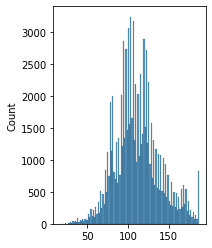

In [6]:
import seaborn as sns

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
sns.histplot(data = liste, ax = ax1)


🧑🏻‍🏫 Remember that Neural Networks are fed with tensors, batch per batch. The shape of these tensors is the following:


>`(# SEQUENCES, # OBSERVATIONS per sequence, # FEATURES per observation)`

- `# SEQUENCES` = $87554$ sequences
- `# OBSERVATIONS per sequence` = ❗️***the number of observations varies from one sequence to another one***❗️ 
- `# FEATURES per observation` = each observation collects "only" $1$ feature = the amplitude of the ECG.

😰 Such a tensor is called a ***ragged tensor***. For computational reasons, this cannot be fed into a Recurrent Neural Network. 

💡 RNNs need to be fed with proper tensors. For this reason, you need to "***fill in the blanks of each sequence***". Using [**`pad_sequences`**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences), each sequence will be filled with fake values. The resulting sequences will all share the same length.

<img src="https://github.com/lewagon/data-images/blob/master/DL/tensors_in_rnn.png?raw=true" alt="Tensors in RNN" width="500" height="600">



❓ **Question** ❓ Apply the [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function directly on X *without any extra arguments here*, store the result in `X_pad` and print the first sequence.

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
X_pad = pad_sequences(X,dtype='float32')

🤔 Surprising, right ? You are probably observing that the returned sequence is composed only of _zeros_. The reason is that, by default, `pad_sequences` returns integers. If a float is between 0.0 and 0.99999..., it will be converted to 0.

❓ **Question** ❓  To change this default behavior, set the `dtype` argument of `pad_sequences` to `float32`. Pad the sequences once again, store the new result in `X_pad` and print the first sequence.

In [9]:
X_pad

array([[0.        , 0.        , 0.        , ..., 0.09803922, 0.09558824,
        0.1127451 ],
       [0.        , 0.        , 0.        , ..., 0.07122507, 0.07692308,
        0.0997151 ],
       [0.        , 0.        , 0.        , ..., 0.03243243, 0.02162162,
        0.05135135],
       ...,
       [0.        , 0.        , 0.        , ..., 0.29387754, 0.3877551 ,
        0.44489795],
       [0.        , 0.        , 0.        , ..., 0.06582279, 0.06582279,
        0.06582279],
       [0.        , 0.        , 0.        , ..., 0.3511008 , 0.35689455,
        0.39281577]], dtype=float32)

👨🏻‍🏫 How will the Recurrent Neural Network know that a zero is a fake value used as a pad for computational reasons ? There is a layer called **`Masking`** layer which will inform the RNN to ignore the fake values. 

❗️ However, if you look closely at the padded version of the first sequence:
* There are padded zeros at the beginning of the sequence. 
    * 👩🏻‍🏫 It is better to pad the zeros at the end of the sequences with the argument `padding = 'post'`
* But, there are also zeros **_in_** the heart-beat values. 
    * 🤨 How could the Neural Network know which zeros to keep and which zeros to ignore?
    * 🧑🏻‍🏫 Instead of using 0 as a fake value by default, choose an absurd value that is easily detectable as fake, for example `value = -1`

📚 [See the full documentation of ***pad_sequences*** here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

❓ **Questions** ❓ Now that you know how to use `pad_sequences`, let's re-do it properly one last time with the two additional arguments aforementioned:
- `padding = 'post'`
- `value = -1`




In [10]:
X_pad = pad_sequences(X,dtype='float32',padding = 'post',value=-1)
X_pad

array([[ 0.97794116,  0.9264706 ,  0.6813725 , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.96011394,  0.8632479 ,  0.46153846, ..., -1.        ,
        -1.        , -1.        ],
       [ 1.        ,  0.6594595 ,  0.18648648, ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 0.90612245,  0.6244898 ,  0.59591836, ..., -1.        ,
        -1.        , -1.        ],
       [ 0.85822785,  0.6455696 ,  0.8455696 , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.90150636,  0.84588647,  0.80069524, ..., -1.        ,
        -1.        , -1.        ]], dtype=float32)

🧪 If you padded properly, the shape of `X_pad` should be equal to $ (87554, 187) $

In [11]:
assert X_pad.shape == (87554, 187)

☝️ We are missing one dimension, the last one (corresponding to the number of features per observation)

❓ **Question** ❓ To fix this issue, expand the last dimension using `expand_dims` function from `Numpy` 

In [12]:
X_pad = np.expand_dims(X_pad, axis=-1)
X_pad.shape

(87554, 187, 1)

In [13]:
assert(X_pad.shape == (87554, 187, 1))

### (1.4) Encoding the categorical targets

❓ **Question** ❓ The labels `y` have to be converted to one-hot-encoded categories. Transform `y` into categories using the appropriate Keras function and store the result into a variable called `y_cat`

In [21]:
from tensorflow.keras.utils import to_categorical

In [22]:
y_cat = to_categorical(
    y, num_classes=5, dtype='float32')

## (2) RNN modeling

❓ **Question** ❓ Split your dataset (the electrocardiograms) between a train and test set (80/20 ratio).

In [23]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2,shuffle=True)

### (2.1) GRU and LSTM

👉 In comparison with the previous challenge, each sequence comprises many observations (187 units of time), and your intuition should tell you that ALL of them matter to detect heart diseases (not just the most "recent" ones). 

🚀 The **LSTM (= Long Short Term Memory)** or the **GRU (= Gated Recurrent Unit)** model, with their ability to *avoid the vanishing gradient problem*, should be preferred over a SimpleRNN.

❓ **Question (RNN architecture)** ❓ 
* Write a model that has the following layers:
    - a Masking layer whose `mask_value` corresponds to the value you decided to pad your data with (it is probably a negative value as suggested) - this layer will simply tell the network not to take into account the computation artifact
    - two stacked `GRU` layers with 20 units each, and the `tanh` as the activation function
    - a dense layer with 50 units
    - a dropout layer with 20% drop
    - a last (predictive) dense layer.
* Print the summary of the model

In [29]:
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras import regularizers, Sequential, layers

In [54]:
def initialize_model():

  # –– Model
  model = Sequential()
  model.add(layers.Masking(mask_value=-1000))
  model.add(GRU(units=20, activation='tanh',return_sequences=True))
  model.add(GRU(units=20, activation='tanh'))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Dense(1, activation='linear'))

  # –– Compilation
  model.compile(loss='mse', 
                optimizer='rmsprop') # Use `rmsprop`
  return model

# # –– Fit
# model.fit(X, y);

In [55]:
model = initialize_model()

In [56]:
model.summary()

ValueError: ignored

❓ **Question (Training)** ❓ Compile and train your model. 

<u>Warning:</u> You will notice that it can take a very long time per epoch, even with GPUs. RNNs are, by nature, harder to distribute than CNNs. Indeed, GPUs work best when `trainable_params` is large (which is not the case here), or when `batch_size` is large 

- To reduce the duration of each epoch, use a larger batch size (e.g 128)

- Use also very small patience equal to 1 should be sufficient. This is because you have a lot of sequences and thus, many optimizations per epochs, even with a relatively large `batch_size`




In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
model = initialize_model()

es = EarlyStopping(patience=20)

history = model.fit(X_train, y_train, 
          batch_size=128, 
          epochs=10, 
          validation_split=0.3,
          callbacks=[es])

Epoch 1/10
384/384 [==============================] - 122s 286ms/step - loss: 0.1606 - val_loss: 0.1600
Epoch 2/10
384/384 [==============================] - 98s 256ms/step - loss: 0.1601 - val_loss: 0.1601
Epoch 3/10
384/384 [==============================] - 99s 258ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 4/10
384/384 [==============================] - 98s 254ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 5/10
384/384 [==============================] - 97s 254ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 6/10
384/384 [==============================] - 98s 255ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 7/10
384/384 [==============================] - 98s 255ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 8/10
384/384 [==============================] - 97s 254ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 9/10
384/384 [==============================] - 98s 254ms/step - loss: 0.1600 - val_loss: 0.1600
Epoch 10/10
384/384 [==============================] - 98s 254ms/step - 

In [52]:
 np.array(X_train).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(70043,)

In [43]:
len(X_test), len(X_train)

(17511, 70043)

In [40]:
 X_test_scaled =model.transform(X_test)

❓ **Question (Evaluation)** ❓ Evaluate your model on the test data.

In [58]:
model.evaluate(X_test, y_test, verbose=0)

0.16000092029571533

## (3) Baseline Model

🧑🏻‍🏫 ***In a classification task, a baseline model is to predict the most frequent class of the training set for all the elements in the test set.***

So, what is the accuracy of a baseline model which would predict, for each ECG in `y_test`, the most probable category in `y_train` ? 

* 🎁 We wrote down below the code to compute the baseline accuracy of a multiclass classification task for you.
    * 🧑🏻‍🎓 Make sure you understand the code
* 🕵️‍♀️ Compare the baseline accuracy with the RNN model

In [59]:
# "Training" the baseline model

occurencies_per_heartbeat_category_train = np.sum(y_train, axis=0)
most_frequent_category_train = np.argmax(occurencies_per_heartbeat_category_train)

# "Evaluating" the baseline model: in the test set, a baseline model will always predict
# the most frequent class found in the train set

occurencies_per_heartbeat_category_test = np.sum(y_test, axis=0)
number_of_correct_predictions = occurencies_per_heartbeat_category_test[most_frequent_category_train]
baseline_accuracy = number_of_correct_predictions/len(y_test)
print(f'Baseline accuracy = {baseline_accuracy}')

Baseline accuracy = 0.8267374792987265


👆 Basically, the RNN that we designed earler turns out to be as good/bad as a baseline model that predicts the most present category... 

🕵🏻 Let's try to deep dive into the predictions of the RNN model.

❓ **Question** ❓ Use the *predict* function to check what categories are predicted by the RNN model. Compare the distribution of the predictions with the distributions of the classes in the training set. What do you notice ?

In [60]:
model.predict(X_test)

array([[0.20050882],
       [0.20050882],
       [0.20050882],
       ...,
       [0.20050882],
       [0.20050882],
       [0.20050882]], dtype=float32)

🤨 The RNN model predicts frequencies that are extremely close to the original distribution of the heartbeats in the training set... Why is that ?

* The RNN was trained on a quite ***imbalanced dataset***. We could rebalance the dataset by downsampling the most represented category (normal heartbeats) and oversampling the under-represented categories... But that is not the focus of this chapter on RNN :)
* ***Neural networks require bigger datasets***. The current dataset is *too small* for Neural Networks to learn noticeable facts from it.
* Predicting the category of an ECG for one patient it not an easy task. ***We should have multiple ECGs for each patient to help the RNN learn the patterns of what a "healthy ECG" is***. Unfortunately, in this dataset, there is only ***one*** heartbeat per patient.

❌ Do not try to improve the results here. 

🧑🏻‍🏫 One lesson that we have been teaching you and that we are going to repeat here again and again:
* **Don't be satisfied with any "good" accuracy unless you have compared your model to a baseline model!**

***


🏁 Congratulations 🏁

1. Download this notebook from your `Google Drive` or directly from `Google Colab`
2. Drag-and-drop it from your `Downloads` folder to your local `[GITHUB_USERNAME]/data-challenges/06-Deep-Learning/04-Recurrent-Neural-Networks/02-Classify-Electrocardiograms`

💾 Don't forget to push your:

Follow the usual procedure on your terminal in the `06-Deep-Learning/04-Recurrent-Neural-Networks/02-Classify-Electrocardiograms` Classification folder:
* *git add classify_electrocardiograms.ipynb*
* *git commit -m "I love RNN for ECG"* or whatever meaningful message you want
* *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on File  Locate in Drive.

🚀 It is time to move on to the *Air Pollution* challenge!